## $ZEKROM$
$\text{Zonal Error-bound K-dimensional Reduced Order Models}$

$\text{Real title: Error control for reduced order models (a posteriori error estimator)}$

In [2]:
#@title Imports
try:
    from dolfin import *
except ImportError:
    # Installing fenics on colab if not found
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh"
    !bash "/tmp/fenics-install.sh"
    from dolfin import *

# Matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# numpy
import numpy as np

# scipy
from scipy import sparse
from scipy.linalg import svd

# meshes stuff
from dolfin.cpp.mesh import *
from mshr import *

# utility to clear output
from IPython.display import clear_output

def del_prints():
    clear_output(wait=True)
    print('Done!')
del_prints()


Done!


In [3]:
#@title Plotting function
def myplot(sol_list, titles=None):
    n = len(sol_list)
    if n == 0:
        print("La lista delle soluzioni è vuota.")
        return

    n_cols = min(n, 3)           # max 3 columns
    n_rows = int(np.ceil(n / 3)) # as many rows as we need

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

    if n_rows == 1:
        axes = np.atleast_1d(axes)
    else:
        axes = axes.flatten()

    for i in range(n):
        plt.sca(axes[i])
        p = plot(sol_list[i])
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
        plt.colorbar(p)

    #disable empty subplots
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    del_prints()
    plt.show()

## Descrizione del problema fisico


Definiamo un problema fisico concreto su cui applicare la riduzione di ordine con controllo dell’errore.

Consideriamo l'equazione di Poisson 2D. la **forma forte** è descritta dal sistema

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
u(x;\mu) = g(x;\mu) & \text{su } \partial \Omega
\end{cases}
$$

e, dato $\mu = (\mu_1, \mu_2) \in \mathcal{P} $, scegliamo:

- Diffusività:$\quad a(x; \mu) = 5 + \mu_1 x_1 + \mu_2 x_2 $\
(affine rispetto a $\mu \ \Rightarrow$ utile per la riduzione)

- Dirichlet's condizioni di bordo **non omogenee** (BC):$\quad g(x; \mu) = \mu_1 \left(x_1 + x_1^2 + x_2^2\right) + \mu_2 \left(x_2 + x_1 x_2\right) $ \
(affine rispetto a $\mu \ \Rightarrow$ lifting facile)

- Forzante (termine sorgente):$\quad f(x) = 1 $

\
Per gestire la non omogeneità delle condizioni al bordo utilizziamo una funzione **"Lifting"** per ricondurci al problema omogeneo, quindi:
$$
u_{\text{lift}} := g(x;\mu) \text{ su } \partial\Omega
$$
ora, definendo $ \tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) $ otteniamo che $ \tilde{u} $ risolve il seguente sistema **omogeneo**:

$$
\begin{cases}
- \nabla \cdot (a(x;\mu)\nabla \tilde{u}(x;\mu)) = - \nabla \cdot (a(x;\mu)\nabla u(x;\mu)) = f(x) & \text{in } \Omega \\
\tilde{u}(x;\mu) = u(x;\mu) - u_{\text{lift}}(x;\mu) = g(x;\mu) - g(x;\mu) = 0 & \text{su } \partial \Omega
\end{cases}
$$

\
A questo punto possiamo passare alla **forma debole**, cioè:
Trova $\tilde{u}(\mu) \in H_0^1(\Omega)$ tale che:

$$
\int_\Omega a(x;\mu) \nabla \tilde{u} \cdot \nabla v \ dx + \int_\Omega a(x;\mu) \nabla u_{\text{lift}} \cdot \nabla v \ dx = \int_\Omega f v \ dx,  \quad \forall v \in H_0^1(\Omega)
$$
(ricordando che $ u = \tilde{u} + u_{lift} $)


In [4]:
#@title global variables

# stringhe delle condizioni di contorno e della diffusività
BC_STR =  "mu1 * (x[0] + pow(x[0],2) + pow(x[1],2)) + mu2 * (x[1] + x[0]*x[1])"
A_STR = "5 + mu1*x[0] + mu2*x[1]"

# stringa e valore del forzante
F_STR, F_DEG = "1", 1

# DA FARE
A, B = -1,1

# costanti per la creazione della geometria
RADIUS = 1
CENTER = Point(0, 0)

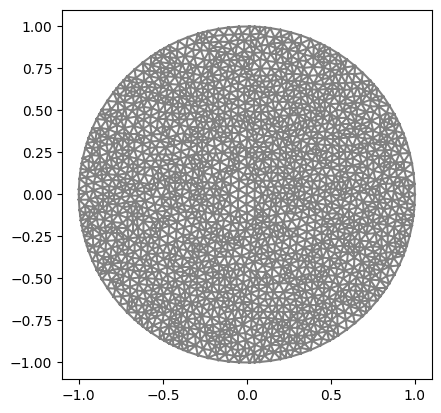

In [5]:
#@title Definizione della geometria $\Omega$
# costruiamo la nostra geometria e generiamo la mesh con circa
# 32 elementi per lato (triangoli di default)

Omega = Circle(CENTER, RADIUS)

mesh = generate_mesh(Omega, 32)
plot(mesh)

DA FARE? spiegazione/introduzione un po' meglio di quello che facciamo dopo

In [6]:
#@title Definiamo $ \langle \varphi_i \rangle $  e  $ V_h $ con $ \varphi_i \in \mathbb{P}^1$

# basis (Lagrangian) functions on our finite element.
V_element = FiniteElement('Lagrange', triangle, 1)
V = FunctionSpace(mesh, V_element) # = V_h
del_prints()

Done!


In [7]:
#@title Definiamo $v$ ed $u$

# trial function that we will use in place of the unknown u in our linear system
u = TrialFunction(V) # represent columns of the system

# test function that we will use to test our problem
v = TestFunction(V)  # represent rows of the system

In [8]:
#@title Parametro $\mu$

mu1 = Constant(1.0)
mu2 = Constant(1.0)
m1, m2 = 0.5, -1

mu1.assign(m1)
mu2.assign(m2)
print(f'utilizzeremo i parametri {m1} e {m2} per i nostri primi test')

utilizzeremo i parametri 0.5 e -1 per i nostri primi test


In [9]:
#@title Diffusività

a_expr = Expression(A_STR, degree=1, mu1=mu1, mu2=mu2)
print('utilizziamo a(x; mu) =', A_STR)

utilizziamo a(x; mu) = 5 + mu1*x[0] + mu2*x[1]


In [10]:
#@title Condizioni al bordo

g_expr = Expression(BC_STR, degree=2, mu1=mu1, mu2=mu2)
BC = DirichletBC(V, g_expr, "on_boundary")
print("usiamo condizioni al bordo g(x; mu) = " + BC_STR)

usiamo condizioni al bordo g(x; mu) = mu1 * (x[0] + pow(x[0],2) + pow(x[1],2)) + mu2 * (x[1] + x[0]*x[1])


### Considerazioni teoriche


Il problema è **coercivo** (Poisson su dominio limitato con $a(x;\mu) \geq 3$) \
- Ricordiamo che:\
data una forma bilineare $a(u,v;\mu)$ diciamo che questa è coerciva se $a(u,v;\mu) \geq \alpha(\mu) \ ||v||^2_{H_0^1}$ con $\alpha(\mu)$ coefficiente di coercività.
- in altre parole:
  - $a(\cdot,\cdot;\mu)$ controlla la norma $ ||v||$
  - Nessuna "direzione" di $v$ può sfuggire al controllo (nessuna degenerazione)

\
Nel nostro caso abbiamo:

1. $a(x;\mu) \geq \underline{a} > 0$ per ogni $x \in \Omega$, $\mu \in \mathcal{P}$  
   - $ a(x; \mu) = 5 + \mu_1 x_1 + \mu_2 x_2 \geq 1 \Rightarrow \alpha(\mu) \geq 1$

2. Il dominio $\Omega$ è limitato e regolare, quindi:
   - Poincaré: $\|v\|_{L^2} \leq C \|\nabla v\|$ \
   $\Rightarrow$ la norma $H^1_0$ è equivalente a $\|\nabla v\|$

3. La forma bilineare è:
   $$
   a(u, v; \mu) = \int_{\Omega} a(x; \mu)\, \nabla u(x) \cdot \nabla v(x) \, dx
   $$
   Esplicitamente:
   $$
   a(u, v; \mu) =
\int_{\Omega} \left(5 + \mu_1 x_1 + \mu_2 x_2\right) \nabla u \cdot \nabla v \, dx =
   $$

   $$
    = \underbrace{\int_{\Omega} 5\, \nabla u \cdot \nabla v \, dx}_{=: a_0(u, v)}
   + \mu_1 \underbrace{\int_{\Omega} x_1\, \nabla u \cdot \nabla v \, dx}_{=: a_1(u, v)}
   + \mu_2 \underbrace{\int_{\Omega} x_2\, \nabla u \cdot \nabla v \, dx}_{=: a_2(u, v)}
   $$

   che è **simmetrica**, **positiva definita**, e **uniformemente ellittica**


\
Otteniamo quindi:
- Esistenza e unicità della soluzione per il teorema di Lax-Milgram
- Stabilità numerica per Finite Element Method (FEM)
- Errori stimabili a posteriori
- RBM certificabile cioè è possibile stimare l’errore tra soluzione ridotta e completa

## FEM


Riscriviamo l'incognita della PDE come
$$
u = w + u_{\text{lift}},
$$
dove
$$
w|_{\partial \Omega} = 0, \quad u_{\text{lift}}|_{\partial \Omega} = g(x; \mu),
$$
cioè $u_{\text{lift}}$ estende la condizione al bordo all'interno del dominio.

Con coefficiente diffusivo $a(x; \mu)$, la PDE per $w$ diventa:
$$
- \nabla \cdot (a(x; \mu) \nabla w) = f - \nabla \cdot (a(x; \mu) \nabla u_{\text{lift}}) \quad \text{in } \Omega,
$$
con
$$
w|_{\partial \Omega} = 0.
$$

In [11]:
#@title Calcolo LHS e RHS per $u_{lift}$ (problema con lifting)

# defining lifting function u_lift, tc u_lift = g on ∂Ω
u_lift = TrialFunction(V) # satisfy BC g

# solve -Δ(u_lift) = 0 with u_lift = g on ∂Ω
lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
rhs_lift = Constant(0.0) * v * dx

LHS_lift = assemble(lhs_lift)
RSH_lift = assemble(rhs_lift)

BC.apply(LHS_lift)
BC.apply(RSH_lift)

del_prints()
print(type(LHS_lift), type(u_lift), type(RSH_lift))

Done!
<class 'dolfin.cpp.la.Matrix'> <class 'dolfin.function.argument.Argument'> <class 'dolfin.cpp.la.Vector'>


In [12]:
#@title Risoluzione per $u_{lift}$
ul_sol = Function(V)
solve(LHS_lift, ul_sol.vector(), RSH_lift)

1

In [13]:
#@title Calcolo LHS e RHS per $w:=\tilde{u}$ (problema omogeneo)

#Right-hand side of omogenous problem f + Δ(u_lift) = f - div * ( grad(u_lift) )
f = Expression(F_STR, degree=F_DEG)
rhs_expr = f -div(grad(ul_sol))

# solve for w in: -Δw = f + Δ(u_lift), w = 0 su ∂Ω
w = TrialFunction(V)
lhs_w = a_expr * inner(grad(w), grad(v)) * dx
rhs_w = rhs_expr * v * dx

LHS_w = assemble(lhs_w)
RHS_w = assemble(rhs_w)

zero_BC = DirichletBC(V, 0.0, "on_boundary")
zero_BC.apply(LHS_w)
zero_BC.apply(RHS_w)

del_prints()

Done!


In [14]:
#@title Risoluzione per $w$

w_sol = Function(V)
solve(LHS_w, w_sol.vector(), RHS_w)

1

In [15]:
#@title Unione dei due risultati

# compute final solution: u = w + u_lift
u_sol = Function(V)
u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

Done!


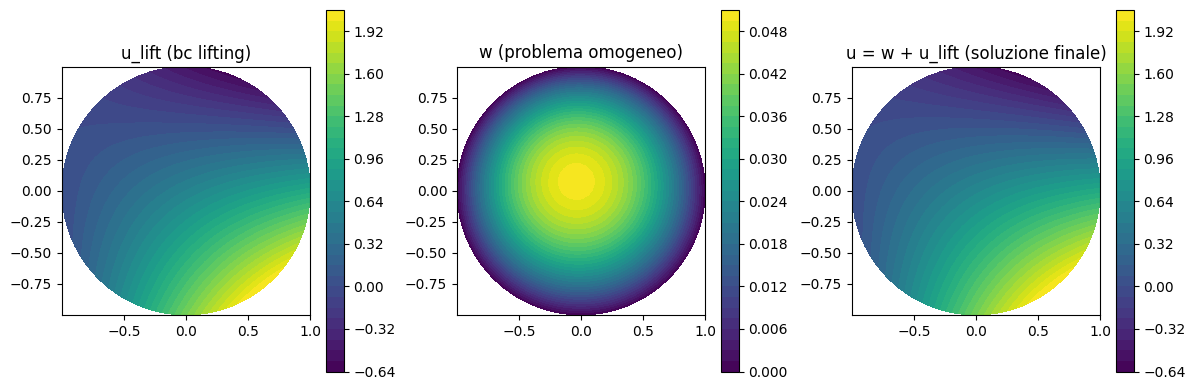

mu_1 = 0.5  ;  mu_2 = -1.0


In [16]:
#@title Solutions plots

myplot([ ul_sol              ,  w_sol                 ,  u_sol                             ],
          ["u_lift (bc lifting)", "w (problema omogeneo)", "u = w + u_lift (soluzione finale)"])
print('mu_1 =',float(mu1), ' ; ','mu_2 =', float(mu2))

In [17]:
#@title Numero di gradi di libertà

N_dofs = len(u_sol.vector())
N_dofs

2022

### Truth solver

In [18]:
def solve_for(V, mu1_val,mu2_val):

    u = TrialFunction(V)
    v = TestFunction(V)

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)
    g_expr = Expression(BC_STR, degree=2, mu1=mu1, mu2=mu2)
    a_expr = Expression(A_STR , degree=1, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    u_lift = TrialFunction(V)
    lhs_lift = a_expr * inner(grad(u_lift), grad(v)) * dx
    rhs_lift = Constant(0.0) * v * dx

    LHS_lift = assemble(lhs_lift)
    RSH_lift = assemble(rhs_lift)
    BC.apply(LHS_lift)
    BC.apply(RSH_lift)
    ul_sol = Function(V)
    solve(LHS_lift, ul_sol.vector(), RSH_lift)

    f = Expression(F_STR, degree=F_DEG)
    rhs_expr = f + -div(grad(ul_sol))
    w = TrialFunction(V)
    lhs_w = a_expr * inner(grad(w), grad(v)) * dx
    rhs_w = rhs_expr * v * dx

    LHS_w = assemble(lhs_w)
    RHS_w = assemble(rhs_w)

    zero_BC = DirichletBC(V, 0.0, "on_boundary")
    zero_BC.apply(LHS_w)
    zero_BC.apply(RHS_w)

    w_sol = Function(V)
    solve(LHS_w, w_sol.vector(), RHS_w)

    u_sol = Function(V)
    u_sol.vector()[:] = w_sol.vector() + ul_sol.vector()

    del_prints()
    return ul_sol.copy(deepcopy=True), w_sol.copy(deepcopy=True), u_sol.copy(deepcopy=True)

In [19]:
ul_sol, w_sol, u_sol = solve_for(V, mu1_val = m1, mu2_val = m2)
#myplot([ul_sol, w_sol, u_sol]) # check that we have the same solutions to double check

Done!


## RBM

### Offline stage

Costruiamo il **manifold delle soluzioni**:

$$
\mathcal{M}_\delta = \{ u_\delta(\mu) \mid \mu \in \mathcal{P} \}
$$

dove ogni $u_\delta(\mu)$ è ottenuta risolvendo il problema completo per un parametro $\mu = (\mu_1, \mu_2)$ nel sottospazio scelto dallo spazio dei parametri. Queste soluzioni si chiamano **snapshots**.


In [20]:
#@title $\mu$ grid

# build our parameter grid
mus = np.array([[m_1, m_2] for m_1 in np.linspace(A, B, 5) for m_2 in np.linspace(A, B, 5)])
M = len(mus)
M

25

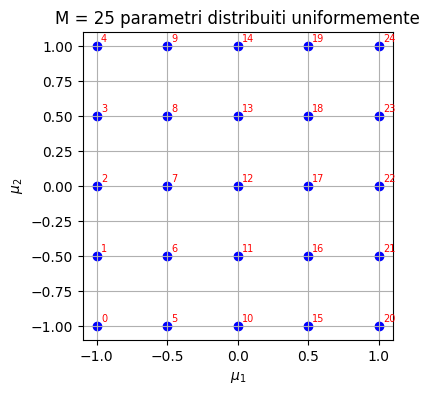

In [21]:
#@title Visualizzazione

plt.figure(figsize=(4, 4))
plt.scatter(mus[:, 0], mus[:, 1], c='blue', label='Parametri selezionati')

for k, (x, y) in enumerate(mus):
    plt.text(x + 0.03, y + 0.03, str(k), fontsize=7, color='red')

plt.grid(True)
plt.title(f"M = {M} parametri distribuiti uniformemente")
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.show()

In [22]:
#@title Costruiamo la matrice $U$ di snapshots con dimensionalità $ \ N_{dofs} \times M$ con $N_{dofs} := N_{\delta}$

U = np.zeros(shape=(N_dofs,M))
j = 0

np.random.seed(42) #set seed to have same result each time
np.random.shuffle(mus)

for m_1, m_2 in mus:
    _, _, u_sol = solve_for(V, m_1, m_2)
    U[:,j]=u_sol.vector().get_local()
    j+=1

Done!


Done!


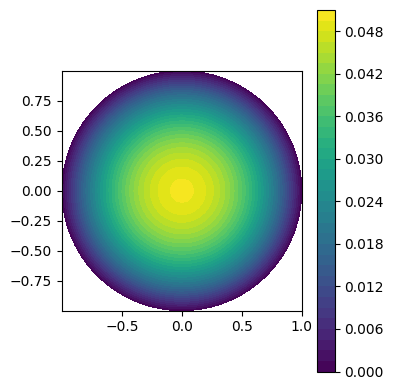

In [23]:
#@title Visualizziamo le soluzioni trovate (se vogliamo)
we_want = True #@param {type:"boolean"}


# siamo passati da  u_sol -----------------------------> u_sol.vector() -------------> u_sol.vector().get_local())
#        quindi da 'dolfin.function.function.Function'->'dolfin.cpp.la.PETScVector'->'numpy.ndarray'
# torniamo da class 'numpy.ndarray a class 'dolfin.function.function.Function'>

if we_want:
    i1 = np.random.randint(0, M)
    u1 = Function(V)
    u1.vector().set_local(U[:,i1]); u1.vector().apply("insert")

    myplot([u1])

Ora utilizziamo la **Proper Orthogonal Decomposition (POD)** per ottenere una base ridotta ottimale nel senso $L^2$.

Si considera la matrice dei dati:

$$
U = [u_\delta(\mu_1), u_\delta(\mu_2), \ldots, u_\delta(\mu_M)] \in \mathbb{R}^{N_\delta \times M}
$$

e si effettua la decomposizione SVD:

$$
U = W \Sigma V^T
$$

Gli autovettori singolari sinistri $\xi_i$ (colonne di $U_{svd} := W$) sono le funzioni base e proendendo i primi $K$ formiamo la base ridotta:

$$
V_{\text{rb}} = \text{span}\{\xi_1, \ldots, \xi_K\}
$$

che minimizza l'errore medio tra gli snapshot e le loro proiezioni.


In [24]:
#@title Eseguiamo la SVD e riduciamo

U_svd, S, VT = svd(U, full_matrices=False)

print(U.shape)

# Numero di funzioni base ridotte da conservare
K = 9
RB = U_svd[:, :K]  # colonne = basi ridotte, N_dofs x K

print(f"Costruito spazio ridotto con K = {K} basi su {U.shape[0]} DOF originali.")
print(f'la dimensione della nostra base ridotta è {RB.shape}')

(2022, 25)
Costruito spazio ridotto con K = 9 basi su 2022 DOF originali.
la dimensione della nostra base ridotta è (2022, 9)


Ora plottando la matrice S possiamo visualizzare quanto valgono i valori singolari, questo ci da un idea di quanto possiamo ridurre le basi

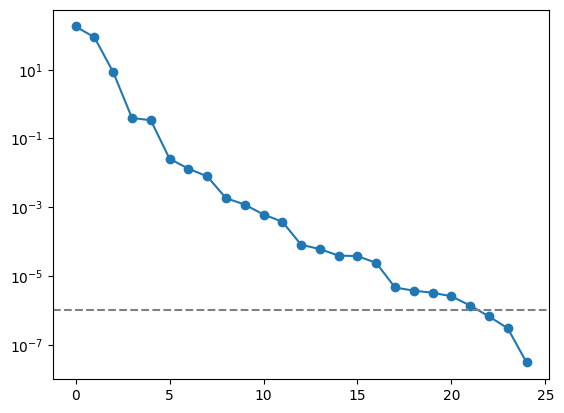

In [25]:
plt.semilogy(S, 'o-')
plt.axhline(1e-6, color='gray', linestyle='--')

### Online stage

Dato il sottospazio ridotto $V_{\text{rb}} = \text{span}\{\xi_1, \dots, \xi_K\}$, si cerca $u_{\text{rb}}(\mu) \in V_{\text{rb}}$ tale che soddisfi la **proiezione di Galerkin**, cioè tale che:

$$
a(u_{\text{rb}}(\mu), v; \mu) = f(v; \mu) \quad \forall v \in V_{\text{rb}}
$$

In pratica, il problema viene proiettato sulla base ridotta, riducendo drasticamente il costo computazionale. come facciamo?

Data una nuova coppia di parametri $\mu = (\mu_1, \mu_2)$, vogliamo:

1. Costruire il lifting per soddisfare le condizioni al bordo non omogenee.
2. Proiettare il problema variazionale nello spazio ridotto.
3. Risolviamo un sistema lineare piccolo di dimensione $K \times K$.
4. Ricostruiamo la soluzione approssimata:

$$
u_{rb}(x; \mu) \approx u_{lift}(x; \mu) + \sum_{i=1}^K c_i(\mu) \xi_i(x)
$$


Ora servono:

- La matrice ridotta:
  $ A_{\text{red}} = \Phi^T A \Phi $
- Il termine noto ridotto:
  $ b_{\text{red}} = \Phi^T (b - A u_L) $

In [26]:
#@title Funzione per il calcolo del lifting

def compute_lift(V, mu1_val, mu2_val):

    u_lift = TrialFunction(V)
    v      = TestFunction(V)

    mu1 = Constant(mu1_val)
    mu2 = Constant(mu2_val)
    a_expr = Expression(A_STR , degree=1, mu1=mu1, mu2=mu2)
    g_expr = Expression(BC_STR, degree=2, mu1=mu1, mu2=mu2)
    BC = DirichletBC(V, g_expr, "on_boundary")

    a_form = a_expr * inner(grad(u_lift), grad(v)) * dx
    L_form = Constant(0.0) * v * dx

    A = assemble(a_form)
    b = assemble(L_form)
    BC.apply(A, b)

    u_lift_sol = Function(V)
    solve(A, u_lift_sol.vector(), b)

    del_prints()
    return u_lift_sol

In [27]:
#@title Funzione per calcolo di $u_{rb}$

def solve_online(V, RB, mu1_val, mu2_val, pre_lift=False):

    mu1 = Constant(1.0)
    mu2 = Constant(1.0)
    mu1.assign(mu1_val)
    mu2.assign(mu2_val)

    # compute lifting
    if pre_lift: u_lift = compute_lift_affine(m1, m2, u1_parts, u2_parts, V)
    else: u_lift = compute_lift(V, mu1_val, mu2_val)

    #modified residual assembly
    u = TrialFunction(V)
    v = TestFunction(V)

    a_expr = Expression(A_STR , degree=1, mu1=mu1, mu2=mu2)
    f = Expression(F_STR, degree=F_DEG)
    rhs_expr = f - div(grad(u_lift))

    a_form = a_expr * inner(grad(u), grad(v)) * dx
    f_form = rhs_expr * v * dx

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    A, F = assemble_system(a_form, f_form, bc)

    # convert sparse fenics matrix to sparse scipy matrix
    A_csr = as_backend_type(A).mat().getValuesCSR()
    A_mat = sparse.csr_matrix((A_csr[2], A_csr[1], A_csr[0]))
    f_vec = F.get_local()

    # projection onto the reduced subspace
    A_rb = RB.T @ A_mat @ RB
    f_rb = RB.T @ f_vec
    u_rb_coeffs = np.linalg.solve(A_rb, f_rb)

    # reconstruction of the final solution
    u_rb_vec = RB @ u_rb_coeffs
    u_high_vec = u_rb_vec

    # adding lifting
    u_total = Function(V)
    u_total.vector()[:] = u_high_vec + u_lift.vector()

    del_prints()
    return u_total

Confrontiamo ora la soluzione completa vista prima

Done!


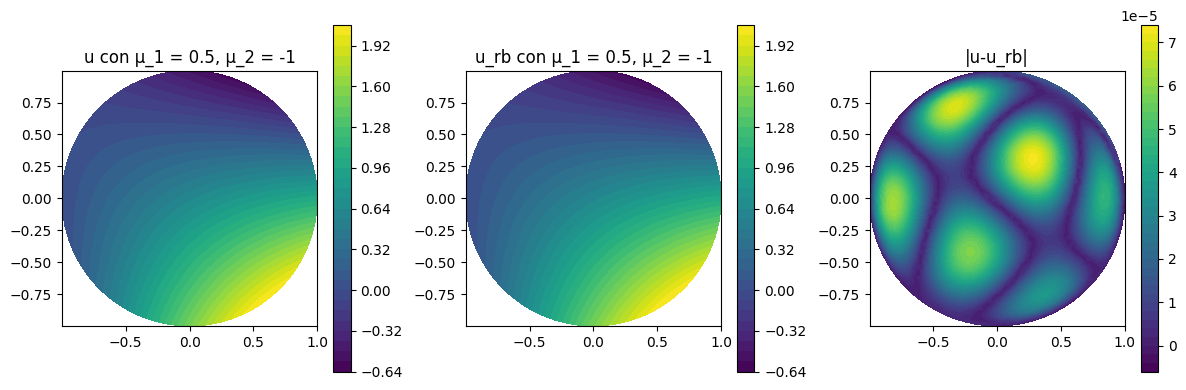

l'errore relativo è 3.769391729884312e-05 
la differenza massima è 7.281690933302887e-05 
la differenza minima è 1.6402036275399781e-09 


In [28]:
#@title Plot comparazione u_lift

_, _, u_full = solve_for(V, m1, m2)
u_rb = solve_online(V, RB, m1, m2)
rel_err = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

r = np.abs(u_full - u_rb)
difmax = np.max(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))
difmin = np.min(np.abs(u_rb.vector().get_local() - u_full.vector().get_local()))

myplot([u_full, u_rb, r],
          [f'u con μ_1 = {m1}, μ_2 = {m2}', f'u_rb con μ_1 = {m1}, μ_2 = {m2}', f'|u-u_rb|'])
print(f"l'errore relativo è {rel_err} ")
print(f"la differenza massima è {difmax} ")
print(f"la differenza minima è {difmin} ")


Molto bene! ora proviamo a farlo per più parametri scelti casualmente così come benchmark

In [29]:
#@title Funzione calcolo errore relativo per $ \{ \mu_{test}^{(1)},..., \mu_{test}^{(\text{test_size})} \} $  scelti casualmente
def test_rbm_accuracy(V, RB, test_size=5):

    test_mus = np.random.uniform(A, B, (test_size, 2))
    errors = np.zeros((test_size,))

    for i,m in enumerate(test_mus):
        m_1,m_2 = m
        _, _, u_full = solve_for(V, m_1, m_2)
        u_rb = solve_online(V, RB, m_1, m_2)
        errors[i] = np.linalg.norm(u_rb.vector().get_local() - u_full.vector().get_local()) / np.linalg.norm(u_full.vector().get_local())

    # stats
    err_mean = np.mean(errors)
    err_max = np.max(errors)
    err_min = np.min(errors)

    print("\nStatistiche errori:")
    print(f"Errore medio   : {err_mean}")
    print(f"Errore massimo : {err_max}")
    print(f"Errore minimo  : {err_min}")

    return test_mus, errors

In [30]:
np.random.seed(42)
test_mus, errors = test_rbm_accuracy(V, RB, test_size=30)

Done!

Statistiche errori:
Errore medio   : 1.613474946945773e-05
Errore massimo : 3.9251397505663674e-05
Errore minimo  : 2.167526488918631e-06


Perfetto gli errori restano piccoli anche con $\mu$ scelti casualmente

## Min-Theta

Stima dell'errore tramite residuo:

Per un problema coercivo si può stimare l'errore nella norma energetica:

$$
\| u_\delta(\mu) - u_{\text{rb}}(\mu) \|_V \leq \frac{ \| r(\cdot; \mu) \|_{V'} }{ \sqrt{ \alpha_{\text{LB}}(\mu) } }
$$

dove $r(\cdot; \mu)$ è il **residuo**:

$$
r(v; \mu) = f(v; \mu) - a(u_{\text{rb}}(\mu), v; \mu)
$$

e $\alpha_{\text{LB}}(\mu)$ è un lower bound della costante di coercività. In molti casi può essere noto o stimato tramite **min-theta** o **SCM**.


In [31]:
#@title Calcolo delle costanti di coercività
def compute_coercivity_constants(V, mus, k_eigs=10, eps_pos=1e-14):
    alphas = np.zeros(len(mus))
    u, v = TrialFunction(V), TestFunction(V)
    bc   = DirichletBC(V, Constant(0.0), "on_boundary")

    for i, (mu1_val, mu2_val) in enumerate(mus):
        mu1, mu2 = Constant(mu1_val), Constant(mu2_val)
        a_expr = Expression(A_STR, degree=1,
                            mu1=mu1, mu2=mu2, domain=mesh)

        A = assemble(a_expr * inner(grad(u), grad(v)) * dx)
        M = assemble(inner(grad(u), grad(v)) * dx + inner(u, v) * dx)
        bc.apply(A); bc.apply(M)

        iaA, jaA, dataA = as_backend_type(A).mat().getValuesCSR()
        iaM, jaM, dataM = as_backend_type(M).mat().getValuesCSR()
        n     = V.dim()
        A_csr = sparse.csr_matrix((dataA, jaA, iaA), shape=(n, n))
        M_csr = sparse.csr_matrix((dataM, jaM, iaM), shape=(n, n))

        eigvals = sparse.linalg.eigsh(
                    A_csr, k=k_eigs, M=M_csr,
                    which='SM', tol=1e-9, return_eigenvectors=False)

        pos_vals = [val for val in sorted(eigvals) if val > eps_pos]
        alphas[i] = pos_vals[0] if pos_vals else np.nan

        print(f"μ = ({mu1_val:+.2f}, {mu2_val:+.2f}) → α(μ) = {alphas[i]:.6e}")

    return alphas

In [32]:
#@title Calcolo dei coefficienti theta
def compute_theta_coefficients(mus, alphas):
    # build matrx of the linear system for the regression

    M = len(mus)
    A = np.zeros((M, 3))
    b = np.zeros(M)

    for i, (mu1, mu2) in enumerate(mus):
        A[i, 0] = 1.0
        A[i, 1] = mu1
        A[i, 2] = mu2
        b[i] = alphas[i]

    # solving with least squares
    theta, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

    print("\nCoefficienti theta ottenuti:")
    print(f"θ0 = {theta[0]:.6f}")
    print(f"θ1 = {theta[1]:.6f}")
    print(f"θ2 = {theta[2]:.6f}")
    print(f"Residui: {residuals}")

    return theta

In [33]:
#@title Bound α_LB
def compute_alpha_LB(mu):
    """
    α_LB(μ) = (5 − ½|μ1| − ½|μ2|) · λ_min^ref    (sempre > 0 per |μi|≤1)
    """
    mu1, mu2 = mu
    a_min = 5.0 - 0.5*abs(mu1) - 0.5*abs(mu2)
    return a_min

## Min-θ: bound inferiore sulla coercività

Per stimare in modo sicuro l’errore RB servono costanti di coercività
**positive** anche fuori dai punti di training.  
Il *Min-θ algorithm* fornisce proprio un **lower-bound computabile online**
partendo da:

* un **fit affine** di $\alpha(\mu)$ sugli snapshot  
  $ \displaystyle \alpha(\mu)\;\approx\;
     \theta_0 + \theta_1\mu_1 + \theta_2\mu_2 $;

* le **coercività esatte** sui punti di training  
  $ \alpha(\mu^{(m)}) $.

Per un nuovo parametro $ \mu $ definiamo

$$
\boxed{\;
  \alpha_{LB}(\mu) \;=\;
  \max_m \;
        \alpha\!\bigl(\mu^{(m)}\bigr)\,
        \min_{q=0,1,2}
        \frac{\theta_q(\mu)}
             {\theta_q\!\bigl(\mu^{(m)}\bigr)}
\;}
$$

* **Il Massimo** sugli snapshot → garantisce il bound inferiore.  
* **Il Minimo** sui coefficienti affini $ \theta_q $ → cattura la peggior
  direzione possibile.


Quindi la differenza tra offline e online è che:
1. **Offline**  
   calcoliamo $ \alpha(\mu^{(m)}) $ con l’autovalore minimo e
   risolviamo con i quadrati minimi i coefficienti $ \theta $.
2. **Online**  
   con `compute_alpha_LB(mu, θ, mus, alphas)` con poche
   operazioni scalari si ottiene un valore **sempre positivo**, usato nel
   denominatore dello stimatore
   $\;\displaystyle \frac{\lVert r \rVert_{V'}}{\sqrt{\alpha_{LB}(\mu)}}$.

Se l’interpolante affine è abbastanza fedele
(e quindi il residuo di regressione è piccolo) e il set di snapshot è ben distribuito,
il rapporto  
$$
\frac{\text{stima}}{\text{errore vero}}
$$
e l’**indice di effectivity medio** restano nella fascia 1 – 10,

certificandoci così un RBM robusto.


In [34]:
# @title Solve Online
def solve_online_with_error(V, RB, mu1_val, mu2_val):
    """
    Risolve il problema ridotto, calcola lo stimatore con norma duale
    corretta (su w = u - u_lift) e confronta con l'errore effettivo.
    """
    # 1) Reduced solution
    u_rb = solve_online(V, RB, mu1_val, mu2_val)

    # 2) analytical coercivity bound
    alpha_LB = compute_alpha_LB([mu1_val, mu2_val])

    # 3) parameters, diffusivity, lifting
    mu1 = Constant(mu1_val)
    mu2 = Constant(mu2_val)
    a_expr  = Expression(A_STR, degree=1, mu1=mu1, mu2=mu2, domain=mesh)
    u_lift  = compute_lift(V, mu1_val, mu2_val)

    # 4) variational forms
    v = TestFunction(V)
    w = TrialFunction(V)

    a_form   = a_expr * inner(grad(w), grad(v)) * dx
    rhs_expr = Constant(1.0) - div(grad(u_lift))
    f_form   = rhs_expr * v * dx

    bc = DirichletBC(V, Constant(0.0), "on_boundary")
    A, F = assemble_system(a_form, f_form, bc)

    # 5) Residual
    w_rb_vec = u_rb.vector() - u_lift.vector()
    residual = F - A * w_rb_vec

    # 6) dual norm
    z = residual.copy()
    solver = PETScKrylovSolver("cg", "hypre_amg")
    solver.set_operator(A)
    solver.parameters.update({"relative_tolerance": 1e-10,
                              "absolute_tolerance": 1e-12,
                              "monitor_convergence": False})
    solver.solve(z, residual)
    residual_dual_norm = np.sqrt(residual.inner(z))

    error_estimate = residual_dual_norm / np.sqrt(alpha_LB)

    # 7) error using truth solver
    _, _, u_full = solve_for(V, mu1_val, mu2_val)
    true_error = np.linalg.norm(u_rb.vector().get_local()
                                - u_full.vector().get_local()) \
                 / np.linalg.norm(u_full.vector().get_local())

    print(f"\nμ = ({mu1_val:.2f}, {mu2_val:.2f})")
    print(f"α_LB         = {alpha_LB:.6f}")
    print(f"‖r‖_V'       = {residual_dual_norm:.4e}")
    print(f"Stima errore = {error_estimate:.4e}")
    print(f"Errore vero  = {true_error:.4e}")
    print(f"Effectivity  = {error_estimate/true_error:.4f}")

    return u_rb, error_estimate, true_error


In [35]:
alphas = compute_coercivity_constants(V, mus)
theta = compute_theta_coefficients(mus, alphas)

# some testing
test_mus = np.array([[0.2, 0.15], [0.5, -0.3], [-0.8, 0.7], [0.9, 0.9], [-1.0, -1.0]])
for mu in test_mus:
    alpha_LB = compute_alpha_LB(mu)


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_66692e53703a3935bd3e96bde3bae2734a1118fa

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_4168]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.023519 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dfd82b005d6a695fcceda001254f1e05078d0eb0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0183892 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

μ = (-0.50, +0.50) → α(μ) = 6.080311e-01
μ = (+0.50, -0.50) → α(μ) = 7.249434e-02
μ = (-1.00, -1.00) → α(μ) = 3.438818e-02
μ = (+1.00, +0.50) → α(μ) = 1.420641e-02
μ = (+0.00, -0.50) → α(μ) = 4.790165e-01
μ = (-0.50, +1.00) → α(μ) = 2.763429e-01
μ = (+0.00, +0.50) → α(μ) = 1.332463e-01
μ = (-1.00, -0.50) → α(μ) = 4.208292e-01
μ = (+1.00, +0.00) → α(μ) = 1.121396e-02
μ = (-0.50, -1.00) → α(μ) = 6.484259e-02
μ = (-1.00, +0.00) → α(μ) = 2.895624e-02
μ = (+0.00, +0.00) → α(μ) = 1.113593e-01
μ = (+0.50, -1.00) → α(μ) = 1.915928e-01
μ = (-1.00, +0.50) → α(μ) = 2.968130e-01
μ = (-1.00, +1.00) → α(μ) = 1.646721e-01
μ = (+1.00, -1.00) → α(μ) = 3.630850e-02
μ = (+0.50, +0.00) → α(μ) = 6.609896e-03
μ = (+1.00, -0.50) → α(μ) = 1.532245e-02
μ = (+0.50, +0.50) → α(μ) = 4.926410e-01
μ = (+1.00, +1.00) → α(μ) = 1.902751e-01
μ = (-0.50, +0.00) → α(μ) = 7.350892e-02
μ = (+0.00, -1.00) → α(μ) = 8.015795e-02
μ = (+0.00, +1.00) → α(μ) = 7.465637e-01
μ = (+0.50, +1.00) → α(μ) = 2.304673e-01
μ = (-0.50, -0.5

In [40]:
# @title Test finale
np.random.seed(42)
test_mus = np.random.uniform(-1, 1, (5, 2))

error_estimates = []
true_errors = []

print("\nTest con norma duale:")
for mu1, mu2 in test_mus:
    _, est, true_err = solve_online_with_error(V, RB, mu1, mu2)
    error_estimates.append(est)
    true_errors.append(true_err)

effectivities = np.array(error_estimates) / np.array(true_errors)
print(f"\nIndice di effectivity medio: {np.mean(effectivities):.4f} ")


Done!

μ = (0.20, 0.42)
α_LB         = 4.690812
‖r‖_V'       = 3.2382e-04
Stima errore = 1.4951e-04
Errore vero  = 3.4684e-05
Effectivity  = 4.3107

Indice di effectivity medio: 8.7948 


In [37]:
#@title calcolo degli errori al variare di K
trs, sts, efs = [], [], []
Ks = list(range(1,31))
for K in Ks:
    error_estimates = []
    true_errors = []
    temp_RB = U_svd[:,:K]
    for mu1, mu2 in test_mus:
        _, est, true_err = solve_online_with_error(V, temp_RB, mu1, mu2)
        error_estimates.append(est)
        true_errors.append(true_err)

    st,tr = np.mean(np.array(error_estimates)), np.mean(np.array(true_errors))
    ef = np.mean(np.array(error_estimates) / np.array(true_errors))
    trs.append(tr)
    sts.append(st)
    efs.append(ef)
del_prints()

Done!


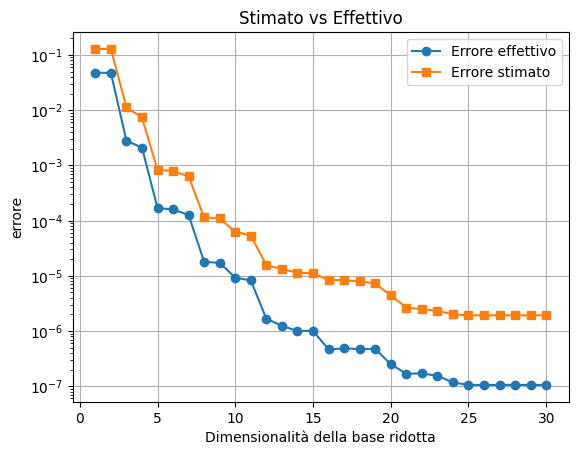

In [38]:
#@title plot dei risultati
plt.semilogy(Ks, trs, label="Errore effettivo", marker='o')
plt.semilogy(Ks, sts, label="Errore stimato", marker='s')
plt.xlabel('Dimensionalità della base ridotta')
plt.ylabel("errore")
plt.title('Stimato vs Effettivo')
plt.legend()
plt.grid(True)
plt.show()